# Project -- Analysing IRA tweets --

In [1]:
import warnings # comment if you want to get the warnings from Searborn... 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import datetime
import matplotlib.pyplot as plt
import findspark

import findspark
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,BooleanType
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this current *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **CONCRETE ANALYSIS**.  We summarized the most important findings since the beginning of the project in a data story like notebook. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [3]:
# taking IRAN tweets into account or not 
include_iran = False

In [7]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [8]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [12]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [13]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [14]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [15]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [16]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [17]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [18]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [19]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [20]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [21]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [22]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [23]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [24]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated and are probably faked by the troll agents. We thus consider it rather useless and prefer dropping it.

In [25]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [26]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [27]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
|Twitter for Black...|     92|
| Twitter for Windows|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [28]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [29]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [30]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [31]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [32]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [33]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [34]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [35]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.
We can tell we won't need to use ADA's cluster.

## 2.  CONCRETE ANALYSIS

As a short reminder, the questions we would like to address are  : 
* 1) Is there a relation between the candidates popularities and the activities of the trolls?
* 2) Did the trolls influence the major events of the campaign? Is it the other way around? 
* 6) Did the strategy of the trolls change over time?
    
-------------------------------------------------------------------------------------------------

**Spark SQL views**

In [36]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

For plotting purposes, let's add another column to the Pandas dataframe which gives the spacing (in terms of number of months) between the months where troll tweets were collected (consistency of the time axis). 

### Temporal and Quantitative analysis

For this first part of the analysis , we work most of the time on *tweet_stats* dataset . We'll also make use of data provided by the following websites : [cesrusc/election](https://cesrusc.org/election/) , [fivethirtyeight/trump-approval-ratings](https://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) , [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#), [wikipedia/campaign_timeline](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election) ).

In [32]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

We can pre-suppose troll *normal_tweets* (when relevant, see below) that have been collected by  [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) are messages advocating, insidiously or not, a preferential political position. At this stage we don't analyze yet the content of these tweets (pure trolls, fake news, researchs ... etc). Retweets and replies may have some influence as well on population's opinion. 

**NOTE** : *Not all the tweets collected are trolls*. Actually all the tweets present in our database were sent by identified troll accounts (at least this is the assumption one has to make while working on this dataset) but for most of these latter they seem to have played the game cleverly. In order not to be spotted immediately as fake foreign accounts they did also manage to ressemble as any other american account. Therefore plenty of '*innocent*' and '*unrelated*' tweets were also written aside by troll accounts for them to pretend to be just normal.

We will investigate this later, let's first show the distribution over time of the number of such *normal_tweets* that may convey the core of the inferences russian trolls wanted to apply on **america's twittosphere**. We do not restrict ourselves yet to any '*time window*' nor specifically '**politically relevant**' troll tweets. 

We just observe the activity flux of russian troll accounts.

In [37]:
# group and count by month (and year)
normal_dates_query = """SELECT COUNT(tweetid) AS count, MAX(tweet_time) AS last_time
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time),MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

normal_dates_pd

,count,last_time
0,20,2009-05-31 17:04:00
1,6,2009-06-23 08:08:00
2,8,2009-07-30 11:44:00
3,14,2009-09-25 10:37:00
4,6,2009-10-25 20:00:00
5,27,2009-11-28 20:36:00
6,118,2009-12-31 21:09:00
7,836,2010-01-31 23:44:00
8,1686,2010-02-28 22:03:00
9,2387,2010-03-31 23:49:00


We can already observe that for some months the database doesn't contain any '*normal tweet*' ! 
Nevertheless there's actually only one month missing (August 2009) since there are 109 records and thus 108 records after the inital one whereas there would have been 109 records after May 2009 if every month was mentionned in the dataframe until June 2018

In [40]:
# recover the date of the first troll normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). The presidential campaign didn't really begin so early thus we will certainly introduce a threshold of validity based on the date of apparition for date-based studies/researchs. As argued above this tweet is probably one old tweet of a '***troll account wannabe***'.

However we may explain why we observe such timestamps by the following other reasons :

* weakness of the filter for troll data collection (false positive troll tweets)
* tweak (did hackers manage to mislead data collectors by faking the date of their tweets?)
* just another bug while recording the informations about the tweets

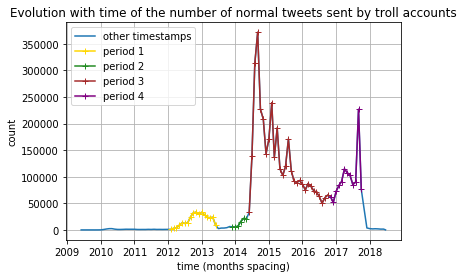

In [321]:
# plot purposes 

# period 1 

period_1_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2012,1,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2013,6,30))]

# period 2 

period_2_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2013,11,30)) & (normal_dates_pd['last_time']<=datetime.datetime(2014,5,31))]

# period 3

period_3_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2014,5,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2016,10,31))]

# period 4 

period_4_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2016,10,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2017,10,31))]


plt.figure(1)
plt.plot(normal_dates_pd['last_time'],normal_dates_pd['count'])
plt.plot(period_1_global_activity['last_time'],period_1_global_activity['count'],marker='+',color='gold')
plt.plot(period_2_global_activity['last_time'],period_2_global_activity['count'],marker='+',color='forestgreen')
plt.plot(period_3_global_activity['last_time'],period_3_global_activity['count'],marker='+',color='brown')
plt.plot(period_4_global_activity['last_time'],period_4_global_activity['count'],marker='+',color='purple')

plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['other timestamps','period 1','period 2','period 3','period 4'],loc=2);

**period 1**

A first increasing trend is observed around 40 months after May 2009. More precisely that small, hill is located in time from February 2012 to June 2013 (increase from $\simeq 3000$ *normal_tweets* per month in February 2012 to $\simeq 34000$ in October 2012 before falling back again, smoothly, to $\simeq 2500$ in June 2013). @explain

**period 2**

Just before period 3 and its interpretation a linear increase of the trollers' activity can be observed. @explain 

**period 3**

We observe a peak starting after 61 months from May 2009 , thus in June 2014. This corresponds exactly to one year prior the moment when Donald Trump announced his candidacy for the primaries (republican) [wikipedia/donald_trump](https://en.wikipedia.org/wiki/Donald_Trump#Political_activities_up_to_2015). 

We'll try to determine whether the ***effective*** troll campaign did really (if it existed) start that month ; maybe to trigger in advance the aimed public.

After the peak the *troll* fever seems to drop monotically until 85 months after the very first tweets : it corresponds to June 2016 before growing up again **right before the final US elections** of november 2016 (90 months). 

**period 4**

Right after the elections the activity of troll accounts isn't decreasing yet. Many contestations of the election results, transition of presidency ... etc make good troll topics. One could observe that until the end ofJanuary 2017, Trump's election wasn't confirmed yet by the congress [wikipedia/header](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election)

Trollers stop after 100 months, at the beginning of the academic year 2017-2018 (end of October 2017).

----------------------------------------------------------------------------------------------------------------------------

Let's have a look at the evolution with the time of the number of *troll* accounts created.   

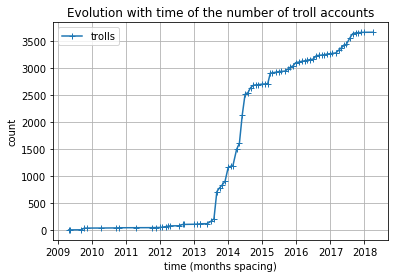

In [117]:
##### @comment
accounts_creation_dates_query = """SELECT MAX(account_creation_date) as last_time, COUNT(userid) as nb_users
                                    FROM tweets_user_sql
                                    GROUP BY YEAR(account_creation_date),MONTH(account_creation_date)
                                    ORDER BY YEAR(account_creation_date),MONTH(account_creation_date) ASC
                                """

accounts_creation_dates_df = spark.sql(accounts_creation_dates_query)

accounts_creation_dates_pd = accounts_creation_dates_df.toPandas()

accounts_creation_dates_pd = accounts_creation_dates_pd.dropna()
accounts_creation_dates_pd.nb_users = accounts_creation_dates_pd.nb_users.cumsum()

plt.figure(1)
plt.plot(accounts_creation_dates_pd['last_time'],accounts_creation_dates_pd['nb_users'],marker='+')
plt.title('Evolution with time of the number of troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['trolls'],loc=2);

----------------------------------------------------------------------------------------------------------------------------

In [43]:
# read of Parquet files about sentiment analysis => only in English

neg_hillary_naive = spark.read.parquet("neg_hillary_naive")
neg_hillary_vader = spark.read.parquet("neg_hillary_vader")
neg_trump_naive = spark.read.parquet("neg_trump_naive")
neg_trump_vader = spark.read.parquet("neg_trump_vader")
neg_obama_naive = spark.read.parquet("neg_obama_naive")
neg_obama_vader = spark.read.parquet("neg_obama_vader")

pos_hillary_naive = spark.read.parquet("pos_hillary_naive")
pos_hillary_vader = spark.read.parquet("pos_hillary_vader")
pos_trump_naive = spark.read.parquet("pos_trump_naive")
pos_trump_vader = spark.read.parquet("pos_trump_vader")
pos_obama_naive = spark.read.parquet("pos_obama_naive")
pos_obama_vader = spark.read.parquet("pos_obama_vader")

In [91]:
def rejoin_query(name):
    return """SELECT normal_tweets_sql.tweetid,userid,tweet_time,in_reply_to_userid,quoted_tweet_tweetid,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices FROM normal_tweets_sql JOIN """ +name+ " ON normal_tweets_sql.tweetid == "+name+".tweetid"

neg_hillary_naive.createOrReplaceTempView("neg_hillary_naive_sql")
neg_hillary_vader.createOrReplaceTempView("neg_hillary_vader_sql")
neg_trump_naive.createOrReplaceTempView("neg_trump_naive_sql")
neg_trump_vader.createOrReplaceTempView("neg_trump_vader_sql")
neg_obama_naive.createOrReplaceTempView("neg_obama_naive_sql")
neg_obama_vader.createOrReplaceTempView("neg_obama_vader_sql")

pos_hillary_naive.createOrReplaceTempView("pos_hillary_naive_sql")
pos_hillary_vader.createOrReplaceTempView("pos_hillary_vader_sql")
pos_trump_naive.createOrReplaceTempView("pos_trump_naive_sql")
pos_trump_vader.createOrReplaceTempView("pos_trump_vader_sql")
pos_obama_naive.createOrReplaceTempView("pos_obama_naive_sql")
pos_obama_vader.createOrReplaceTempView("pos_obama_vader_sql")

## HILLARY CLINTON 

neg_hillary_naive_df = spark.sql(rejoin_query("neg_hillary_naive_sql"))
# @comment if Parquet already built
#neg_hillary_naive_df.write.mode('overwrite').parquet("neg_hil_naive")
neg_hillary_naive_df = spark.read.parquet("neg_hil_naive")

neg_hillary_vader_df = spark.sql(rejoin_query("neg_hillary_vader_sql"))
# @comment if Parquet already built
#neg_hillary_vader_df.write.mode('overwrite').parquet("neg_hil_vader")
neg_hillary_vader_df = spark.read.parquet("neg_hil_vader")

pos_hillary_naive_df = spark.sql(rejoin_query("pos_hillary_naive_sql"))
# @comment if Parquet already built
#pos_hillary_naive_df.write.mode('overwrite').parquet("pos_hil_naive")
pos_hillary_naive_df = spark.read.parquet("pos_hil_naive")

pos_hillary_vader_df = spark.sql(rejoin_query("pos_hillary_vader_sql"))
# @comment if Parquet already built
#pos_hillary_vader_df.write.mode('overwrite').parquet("pos_hil_vader")
pos_hillary_vader_df = spark.read.parquet("pos_hil_vader")

## BARACK OBAMA

neg_obama_naive_df = spark.sql(rejoin_query("neg_obama_naive_sql"))
# @comment if Parquet already built
#neg_obama_naive_df.write.mode('overwrite').parquet("neg_oba_naive")
neg_obama_naive_df = spark.read.parquet("neg_oba_naive")

neg_obama_vader_df = spark.sql(rejoin_query("neg_obama_vader_sql"))
# @comment if Parquet already built
#neg_obama_vader_df.write.mode('overwrite').parquet("neg_oba_vader")
neg_obama_vader_df = spark.read.parquet("neg_oba_vader")

pos_obama_naive_df = spark.sql(rejoin_query("pos_obama_naive_sql"))
# @comment if Parquet already built
# pos_obama_naive_df.write.mode('overwrite').parquet("pos_oba_naive")
pos_obama_naive_df = spark.read.parquet("pos_oba_naive")

pos_obama_vader_df = spark.sql(rejoin_query("pos_obama_vader_sql"))
# @comment if Parquet already built
#pos_obama_vader_df.write.mode('overwrite').parquet("pos_oba_vader")
pos_obama_vader_df = spark.read.parquet("pos_oba_vader")

## DONALD TRUMP

neg_trump_naive_df = spark.sql(rejoin_query("neg_trump_naive_sql"))
# @comment if Parquet already built
#neg_trump_naive_df.write.mode('overwrite').parquet("neg_tru_naive")
neg_trump_naive_df = spark.read.parquet("neg_tru_naive")

neg_trump_vader_df = spark.sql(rejoin_query("neg_trump_vader_sql"))
# @comment if Parquet already built
#neg_trump_vader_df.write.mode('overwrite').parquet("neg_tru_vader")
neg_trump_vader_df = spark.read.parquet("neg_tru_vader")

pos_trump_naive_df = spark.sql(rejoin_query("pos_trump_naive_sql"))
# @comment if Parquet already built
#pos_trump_naive_df.write.mode('overwrite').parquet("pos_tru_naive")
pos_trump_naive_df = spark.read.parquet("pos_tru_naive")

pos_trump_vader_df = spark.sql(rejoin_query("pos_trump_vader_sql"))
# @comment if Parquet already built
#pos_trump_vader_df.write.mode('overwrite').parquet("pos_tru_vader")
pos_trump_vader_df = spark.read.parquet("pos_tru_vader")

In [128]:
grouped_pos_hillary_vader_w_pd = pos_hillary_vader_df.select(pos_hillary_vader_df.tweet_time,pos_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_hillary_vader_w_pd = neg_hillary_vader_df.select(neg_hillary_vader_df.tweet_time,neg_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_pos_hillary_naive_w_pd = pos_hillary_naive_df.select(pos_hillary_naive_df.tweet_time,pos_hillary_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_hillary_naive_w_pd = neg_hillary_naive_df.select(neg_hillary_naive_df.tweet_time,neg_hillary_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_obama_vader_w_pd = pos_obama_vader_df.select(pos_obama_vader_df.tweet_time,pos_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_obama_vader_w_pd = neg_obama_vader_df.select(neg_obama_vader_df.tweet_time,neg_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_pos_obama_naive_w_pd = pos_obama_naive_df.select(pos_obama_naive_df.tweet_time,pos_obama_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_obama_naive_w_pd = neg_obama_naive_df.select(neg_obama_naive_df.tweet_time,neg_obama_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_trump_vader_w_pd = pos_trump_vader_df.select(pos_trump_vader_df.tweet_time,pos_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_trump_vader_w_pd = neg_trump_vader_df.select(neg_trump_vader_df.tweet_time,neg_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_pos_trump_naive_w_pd = pos_trump_naive_df.select(pos_trump_naive_df.tweet_time,pos_trump_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_trump_naive_w_pd = neg_trump_naive_df.select(neg_trump_naive_df.tweet_time,neg_trump_naive_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

Naive

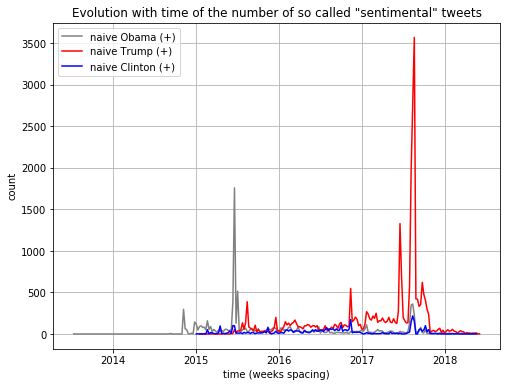

In [129]:
# global evolution of sentiment analysis 
plt.figure(figsize=(8,6))
plt.plot(grouped_pos_obama_naive_w_pd,color="grey",ls="-")
plt.plot(grouped_pos_trump_naive_w_pd,color="red",ls="-")
plt.plot(grouped_pos_hillary_naive_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['naive Obama (+)','naive Trump (+)','naive Clinton (+)'],loc=2);

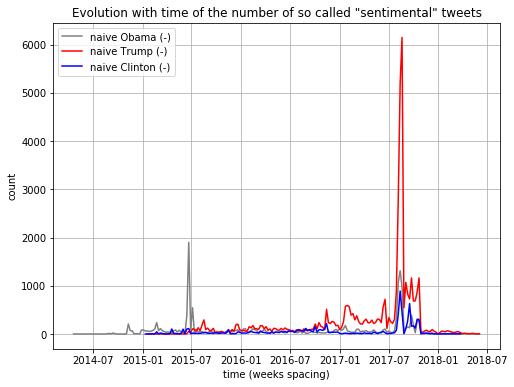

In [130]:
# global evolution of sentiment analysis 
plt.figure(figsize=(8,6))
plt.plot(grouped_neg_obama_naive_w_pd,color="grey",ls="-")
plt.plot(grouped_neg_trump_naive_w_pd,color="red",ls="-")
plt.plot(grouped_neg_hillary_naive_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['naive Obama (-)','naive Trump (-)','naive Clinton (-)'],loc=2);

Vader

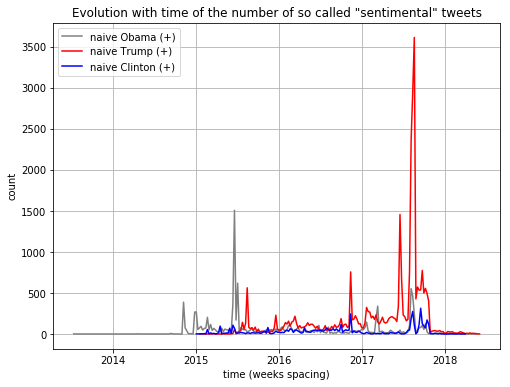

In [131]:
# global evolution of sentiment analysis 
plt.figure(figsize=(8,6))
plt.plot(grouped_pos_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_pos_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_pos_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['naive Obama (+)','naive Trump (+)','naive Clinton (+)'],loc=2);

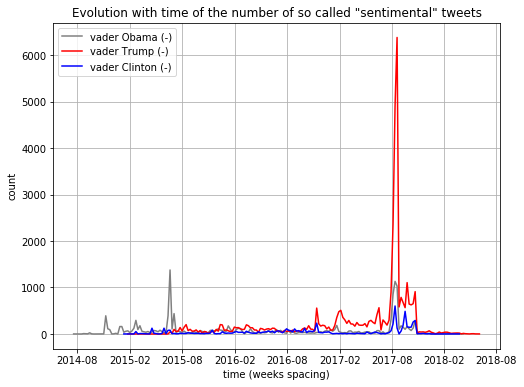

In [132]:
# global evolution of sentiment analysis 
plt.figure(figsize=(8,6))
plt.plot(grouped_neg_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_neg_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_neg_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
#plt.legend(['naive Obama','naive Trump','naive Clinton'],loc=2);
plt.legend(['vader Obama (-)','vader Trump (-)','vader Clinton (-)'],loc=2);

weird peak for *vader* at 430 weeks

We also need to store some obvious stop words that would indicate the theoretical presence of *politically related* tweets. 

In [114]:
stop_words_political = ['Donald','Trump','Дональд','Трамп','Hillary','Clinton','Хиллари','Клинтон',\
                        'Barack','Obama','Барак','Обама','republican','республиканец','democrat','демократ',\
                        'presidential','elections','выборы','президента','votes','голосов','fake news','fakenews','поддельные',\
                       'новости']

----------------------------------------------------------------------------------------------------------------------------

### Time window :  Period 1 (*A sudden increasing Trend*)

In [134]:
normal_tweets_p1_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time >= "2012-02-01" AND tweet_time <= "2013-06-30"
                        """
normal_tweets_p1_df  = spark.sql(normal_tweets_p1_query)

normal_tweets_p1_df.createOrReplaceTempView("normal_tweets_p1_sql")

In [297]:
normal_dates_w_p1_query =  """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                              FROM normal_tweets_p1_sql 
                              GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                              ORDER BY time ASC
                           """
normal_dates_w_p1_df = spark.sql(normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p1_pd = normal_dates_w_p1_df.toPandas()

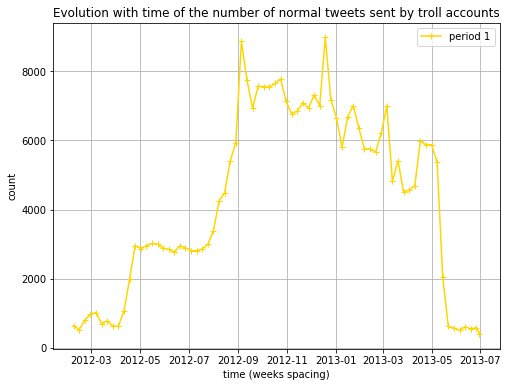

In [331]:
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p1_pd["time"],normal_dates_w_p1_pd["count"],color="gold",marker='+')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 1'],loc=1);

In [166]:
# get texts of the normal tweets corresponding to period 1
normal_tweets_texts_p1_query = """ SELECT normal_tweets_p1_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p1_sql ON tweets_text_sql.tweetid == normal_tweets_p1_sql.tweetid
                               """

normal_tweets_texts_p1_df = spark.sql(normal_tweets_texts_p1_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p1_df.write.mode('overwrite').parquet("normal_tweets_texts_p1_df")

normal_tweets_texts_p1_df = spark.read.parquet("normal_tweets_texts_p1_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p1_df.createOrReplaceTempView("normal_tweets_texts_p1_sql")

In [168]:
political_normal_tweets_texts_p1_df = normal_tweets_texts_p1_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
# political_normal_tweets_texts_p1_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p1_df")

political_normal_tweets_texts_p1_df = spark.read.parquet("political_tweets_texts_p1_df")

In [294]:
political_normal_tweets_texts_p1_df.createOrReplaceTempView("political_normal_tweets_p1_sql")

political_normal_dates_w_p1_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_normal_tweets_p1_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p1_df = spark.sql(political_normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p1_pd = political_normal_dates_w_p1_df.toPandas()

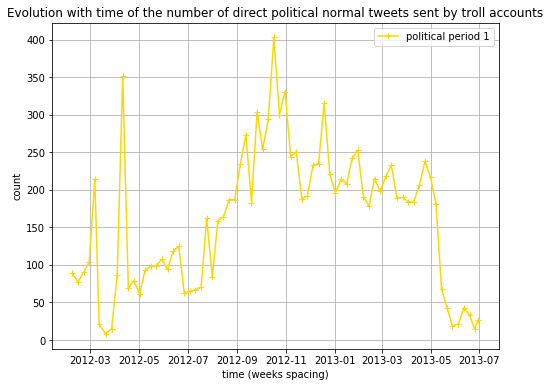

In [330]:
plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p1_pd["time"],political_normal_dates_w_p1_pd["count"],color="gold",marker='+')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 1'],loc=1);

### Time window : Period 2 (*Rising Troll Activities*)

In [179]:
normal_tweets_p2_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2013-11-30" AND tweet_time <= "2014-05-31"
                        """
normal_tweets_p2_df  = spark.sql(normal_tweets_p2_query)

normal_tweets_p2_df.createOrReplaceTempView("normal_tweets_p2_sql")

In [287]:
normal_dates_w_p2_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p2_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2013-12-01")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p2_df = spark.sql(normal_dates_w_p2_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p2_pd = normal_dates_w_p2_df.toPandas()

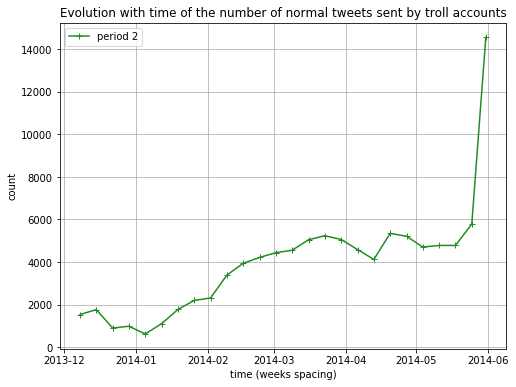

In [329]:
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p2_pd["time"],normal_dates_w_p2_pd["count"],color="forestgreen",marker='+')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 2'],loc=2);

In [183]:
# get texts of the normal tweets corresponding to period 2
normal_tweets_texts_p2_query = """ SELECT normal_tweets_p2_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p2_sql ON tweets_text_sql.tweetid == normal_tweets_p2_sql.tweetid
                               """

normal_tweets_texts_p2_df = spark.sql(normal_tweets_texts_p2_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p2_df.write.mode('overwrite').parquet("normal_tweets_texts_p2_df")

normal_tweets_texts_p2_df = spark.read.parquet("normal_tweets_texts_p2_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p2_df.createOrReplaceTempView("normal_tweets_texts_p2_sql")


In [184]:
political_normal_tweets_texts_p2_df = normal_tweets_texts_p2_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
#political_normal_tweets_texts_p2_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p2_df")

political_normal_tweets_texts_p2_df = spark.read.parquet("political_tweets_texts_p2_df")

In [289]:
political_normal_tweets_texts_p2_df.createOrReplaceTempView("political_normal_tweets_p2_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p2_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                       FROM political_normal_tweets_p2_sql 
                                       GROUP BY CAST(DATEDIFF(tweet_time,"2013-12-01")/7 AS int)
                                       ORDER BY time ASC
                                    """
political_normal_dates_w_p2_df = spark.sql(political_normal_dates_w_p2_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p2_pd = political_normal_dates_w_p2_df.toPandas()

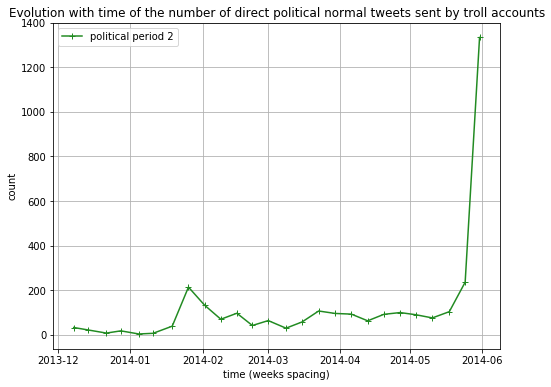

In [328]:
plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p2_pd["time"],political_normal_dates_w_p2_pd["count"],color="forestgreen",marker='+')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 2'],loc=2);

### Time window :  Period 3 (*Presidential Campaign extended*)

Let's now focus on the period of time corresponding to the whole presidential campaign (+ some time before as a flourishing speculative period)

In [190]:
normal_tweets_p3_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2014-05-31" AND tweet_time <= "2016-11-07"
                        """
normal_tweets_p3_df  = spark.sql(normal_tweets_p3_query)

normal_tweets_p3_df.createOrReplaceTempView("normal_tweets_p3_sql")

In [272]:
normal_dates_w_p3_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p3_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2014-05-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p3_df = spark.sql(normal_dates_w_p3_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p3_pd = normal_dates_w_p3_df.toPandas()

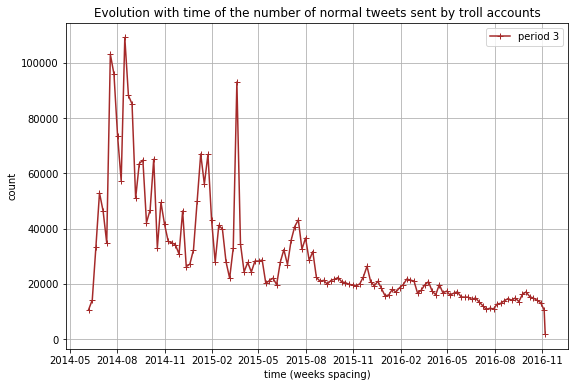

In [327]:
plt.figure(figsize=(9,6))
plt.plot(normal_dates_w_p3_pd["time"],normal_dates_w_p3_pd["count"],color="brown",marker='+')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 3'],loc=1);

In [278]:
# get texts of the normal tweets corresponding to period 3
normal_tweets_texts_p3_query = """ SELECT normal_tweets_p3_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p3_sql ON tweets_text_sql.tweetid == normal_tweets_p3_sql.tweetid
                               """

normal_tweets_texts_p3_df = spark.sql(normal_tweets_texts_p3_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p3_df.write.mode('overwrite').parquet("normal_tweets_texts_p3_df")

normal_tweets_texts_p3_df = spark.read.parquet("normal_tweets_texts_p3_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p3_df.createOrReplaceTempView("normal_tweets_texts_p3_sql")

In [279]:
political_normal_tweets_texts_p3_df = normal_tweets_texts_p3_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
# political_normal_tweets_texts_p3_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p3_df")

political_normal_tweets_texts_p3_df = spark.read.parquet("political_tweets_texts_p3_df")

In [280]:
political_normal_tweets_texts_p3_df.createOrReplaceTempView("political_normal_tweets_p3_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p3_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_normal_tweets_p3_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2014-05-31")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p3_df = spark.sql(political_normal_dates_w_p3_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p3_pd = political_normal_dates_w_p3_df.toPandas()

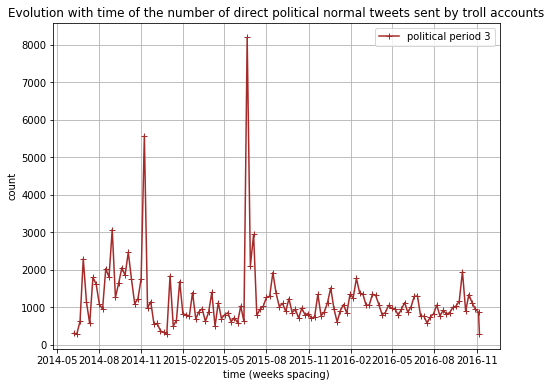

In [326]:
plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p3_pd["time"],political_normal_dates_w_p3_pd["count"],color="brown",marker='+')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 3'],loc=1);

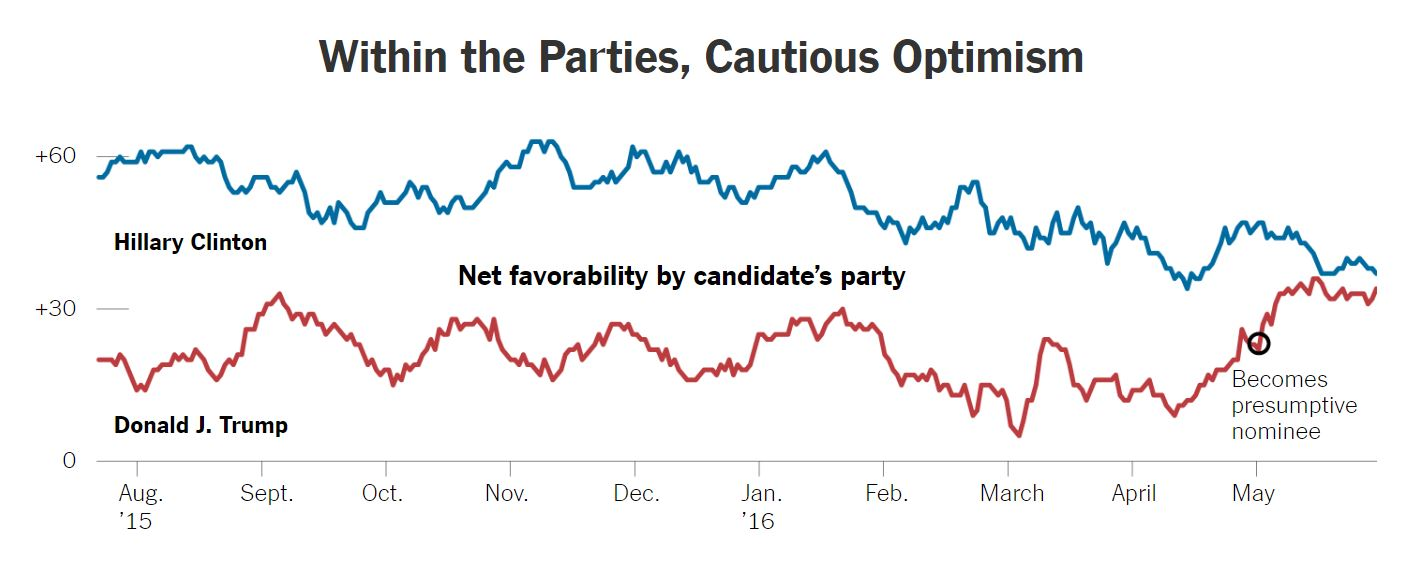

In [92]:
from IPython.display import Image
Image(filename='img/clinton_trump_before_primaries.JPG')

In [344]:
# import intentions of vote after primaries
ap_clinton_trump_votes = pd.read_excel(DATA_DIR+'trump_hillary.xlsx')

In [346]:
datelist = pd.date_range("2016-04-01", periods=221).tolist()

In [375]:
political_normal_dates_ap_d_p3_query =    """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                             FROM political_normal_tweets_p3_sql 
                                             WHERE tweet_time >="2016-03-01"
                                             GROUP BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time)
                                             ORDER BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time) ASC
                                          """
political_normal_dates_ap_d_p3_df = spark.sql(political_normal_dates_ap_d_p3_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_ap_d_p3_pd = political_normal_dates_ap_d_p3_df.toPandas()

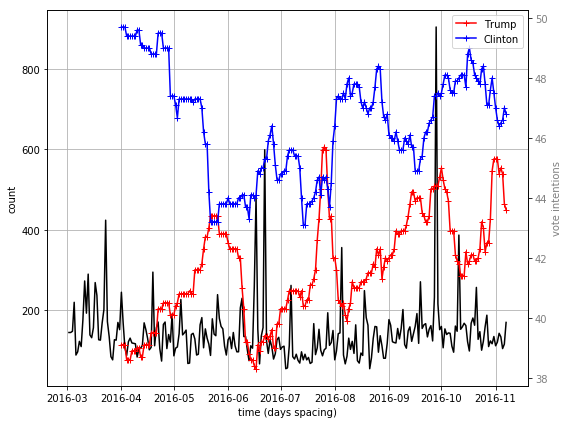

In [377]:
# https://matplotlib.org/gallery/api/two_scales.html

fig, ax1 = plt.subplots(figsize=(8,6))

color = 'grey'
ax1.set_xlabel('time (days spacing)')
ax1.set_ylabel('count', color= "black")
ax1.plot(political_normal_dates_ap_d_p3_pd['time'], political_normal_dates_ap_d_p3_pd['count'], color='black')
ax1.tick_params(axis='y', labelcolor="black")

ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('vote intentions', color=color) 
ax2.plot(datelist,ap_clinton_trump_votes['Trump'], color="red",marker='+')
ax2.plot(datelist,ap_clinton_trump_votes['Hillary'], color="blue",marker='+')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Trump','Clinton'],loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Let's get some basic statistics about the feature *retweet_count* of that same *normal_tweets* dataframe. Goal : to evaluate/assess the importance of troll tweets. We do not dispose of view counts for such tweets but what can be sure about is that there exists a correlation between the number of views and the number of retweets (the more a post is retweeted, the more likely that it reaches more and more people across the internet).

Summary statistics of *retweet_count* of normal tweets vs. statistics of typical 'popular' tweets on Twitter to get a kind of 'popularity scale'. Of course we have to be careful with the data we're dealing with : there might be some automatic retweet nested chains that would bias those results. We'll have to inform ourselves slightly more about that.

In [299]:
# get only the retweets counts 
period_3_rt_counts_query = """SELECT retweet_count AS retweets
                              FROM normal_tweets_p3_sql
                           """
period_3_rt_counts_df = spark.sql(period_3_rt_counts_query)

# relative error tolerance for median computation 
tol = 0.001

print('Summary statistics for RT counts for period 3 normal_tweets : ')
print('--------------------------------------------------------------')
period_3_rt_counts_df.select('retweets').describe().show()
print('approx. 1st quarter quantile : '+str(period_3_rt_counts_df.approxQuantile('retweets',[0.25],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. median : '+str(period_3_rt_counts_df.approxQuantile('retweets',[0.5],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. 3rd quarter quantile : '+str(period_3_rt_counts_df.approxQuantile('retweets',[0.75],tol)[0])+\
      ' for relative error of '+str(tol))

Summary statistics for RT counts for period 3 normal_tweets : 
--------------------------------------------------------------
+-------+------------------+
|summary|          retweets|
+-------+------------------+
|  count|           3820387|
|   mean|3.1766572339399124|
| stddev| 76.33985736248214|
|    min|                 0|
|    max|             97498|
+-------+------------------+

approx. 1st quarter quantile : 0.0 for relative error of 0.001
approx. median : 0.0 for relative error of 0.001
approx. 3rd quarter quantile : 0.0 for relative error of 0.001


$\Rightarrow$  *stddev* is huge and mean is well above 3rd quantile, those statistics seem to indicate a ***power law*** distribution. 

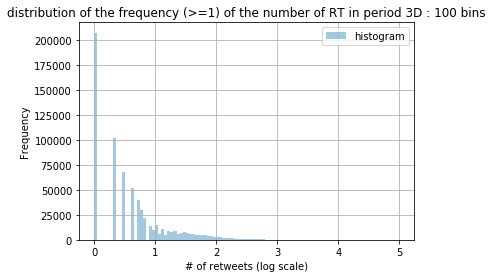

In [300]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_3_rt_counts_sup1_query = """SELECT retweet_count AS retweets
                                   FROM normal_tweets_p3_sql
                                   WHERE retweet_count>=1
                                """
period_3_rt_counts_sup1_df = spark.sql(period_3_rt_counts_sup1_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_3_rt_counts_sup1_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('distribution of the frequency (>=1) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

Among the tweets RT more than $x=10$ times, we can observe the tail under the scope of a zoom ! 

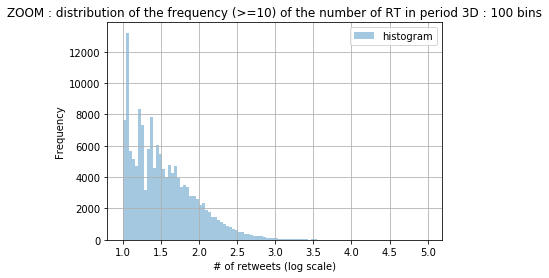

In [301]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_3_rt_counts_sup10_query = """SELECT retweet_count AS retweets
                                FROM normal_tweets_p3_sql
                                WHERE retweet_count>=10 
                             """
period_3_rt_counts_sup10_df = spark.sql(period_3_rt_counts_sup10_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_3_rt_counts_sup10_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('ZOOM : distribution of the frequency (>=10) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

No need to worry already : this is not sufficient evidence that there were no political inference through troll tweets during the US campaign of 2016. 

***But it actually may sustain the hypothesis of the existence of clever RT chains that relay the troll across the web at 'low cost' in terms of RTs.***

We will investigate why there are for the vast majority of the normal tweets, at first sight, so few RT's and if this phenomenon also arises on the reduced time windows mentionned earlier.

Still it can be interesting to extract the most RT normal tweets and have a look at their content (we keep the *tweetid*'s). 

We may also want to discover what is the langage used and to which accounts are linked these tweets (we also keep *userid*).

In [302]:
# get the 1000 (it could be more or less) most RT tweets for period 3

period_3_rt_counts_top_query =     """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p3_sql
                                      ORDER BY retweet_count DESC
                                      LIMIT 1000
                                   """
period_3_rt_counts_top_df = spark.sql(period_3_rt_counts_top_query)

# create temporary Spark SQL view 
period_3_rt_counts_top_df.createOrReplaceTempView("period_3_rt_counts_top_sql")

period_3_rt_counts_top_df.show(10)

+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|           tweetid|    userid|retweet_count|         tweet_time|urls|          tweet_text|tweet_language|like_count|            hashtags|
+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|780901314079318016|4437233895|        97498|2016-09-27 22:45:00|  []|These emotions......|            en|    136013|                  []|
|785614679682846720|4437233895|        41089|2016-10-10 22:55:00|  []|When It’s slowly ...|            en|     46606|      [BlackTwitter]|
|710499812223918080|3312143142|        28568|2016-03-17 16:15:00|  []|!!!!!!DONT LET TH...|            en|     17639|                  []|
|711543567387332608|3312143142|        25169|2016-03-20 13:23:00|  []|He didn’t want a ...|            en|     14748|                  []|
|708741988481282048|3312143

In [303]:
# get the 1000 (it could be more or less) most RT tweets for period 3 || after primaries and before final votes

ap_period_3_rt_counts_top_query =  """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p3_sql
                                      WHERE tweet_time >= "2016-07-07"
                                      ORDER BY retweet_count DESC
                                      LIMIT 100
                                   """
ap_period_3_rt_counts_top_df = spark.sql(ap_period_3_rt_counts_top_query)

# create temporary Spark SQL view 
ap_period_3_rt_counts_top_df.createOrReplaceTempView("ap_period_3_rt_counts_top_sql")

ap_period_3_rt_counts_top_df.show(20)

# to Pandas for further analysis
ap_period_3_rt_counts_top_pd = ap_period_3_rt_counts_top_df.toPandas()

+------------------+----------+-------------+-------------------+--------------------+--------------------+--------------+----------+--------------------+
|           tweetid|    userid|retweet_count|         tweet_time|                urls|          tweet_text|tweet_language|like_count|            hashtags|
+------------------+----------+-------------+-------------------+--------------------+--------------------+--------------+----------+--------------------+
|780901314079318016|4437233895|        97498|2016-09-27 22:45:00|                  []|These emotions......|            en|    136013|                  []|
|785614679682846720|4437233895|        41089|2016-10-10 22:55:00|                  []|When It’s slowly ...|            en|     46606|      [BlackTwitter]|
|784182493868023808|4437233895|        16627|2016-10-07 00:04:00|                  []|Normal???  Anti-r...|            en|     15020|                  []|
|777989058689536000|4437233895|        16104|2016-09-19 21:53:00|     

In [304]:
# interesting account
troll_example_p3 = ap_period_3_rt_counts_top_pd[ap_period_3_rt_counts_top_pd.userid=='4224729994']

In [305]:
troll_example_p3.shape

(47, 9)

$47\%$ of the 100 most RT tweets on the period (July 2016 - November 2016 ; after primaries before final votes) are written by only one troll account !

In [306]:
troll_example_p3

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
4,793890171058085888,4224729994,15548,2016-11-02 18:59:00,[],BREAKING: #VoterFraud by counting tens of thou...,en,10172,[VoterFraud]
7,785663973613899776,4224729994,12716,2016-10-11 02:11:00,[],"OMG, this new Anti-Hillary ad is brilliant!👌 I...",en,10756,[]
9,788450633896562689,4224729994,10824,2016-10-18 18:44:00,[],RT the hell out of it: Dem party operatives: ...,en,6772,[EvangelicalTrump]
14,788978081293819904,4224729994,9323,2016-10-20 05:40:00,[],BREAKING🚨 Hillary shuts down press conferenc...,en,8927,"[VoterFraud, debatenight, TrumpBookReport]"
16,788532197506572296,4224729994,8574,2016-10-19 00:08:00,[],BREAKING🚨 Thousands of names changed on voter...,en,7092,"[VoterFraud, DrainTheSwamp]"
23,788169033841577985,4224729994,6676,2016-10-18 00:05:00,[],OMFG! This is EXPLOSIVE! THE MOST IMPORTANT V...,en,4218,[BillyBushMadeMeDoIt]
25,788098438915297280,4224729994,6303,2016-10-17 19:24:00,[],"""This is sickening. Hillary using the """"Mental...",en,4573,"[FreeJulian, BirdDogging, PodestaEmails10]"
29,792802334602592258,4224729994,5799,2016-10-30 18:56:00,[],RT if you also think that @LorettaLynch should...,en,5210,[gohillary]
32,783728674390544384,4224729994,5058,2016-10-05 18:00:00,[],BREAKING🚨 Hillary caught using a child actor‼️...,en,3413,[WorldTeachersDay]
35,785621909677285376,4224729994,4708,2016-10-10 23:23:00,[],""".@AnnCoulter: """"If Hillary wins",en,4857,[]


### Time window : Period 4 (*Presidential Instability*)

In [308]:
normal_tweets_p4_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2016-10-31" AND tweet_time <= "2017-10-31"
                        """
normal_tweets_p4_df  = spark.sql(normal_tweets_p4_query)

normal_tweets_p4_df.createOrReplaceTempView("normal_tweets_p4_sql")

In [309]:
# group and count by weeks (only the weeks of interest corresponding to the current time window) 
normal_dates_w_p4_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p4_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p4_df = spark.sql(normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p4_pd = normal_dates_w_p4_df.toPandas()

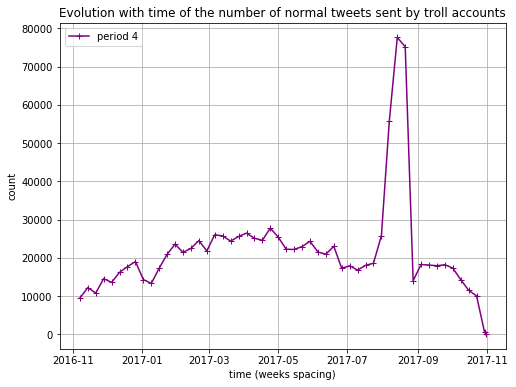

In [336]:
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p4_pd["time"],normal_dates_w_p4_pd["count"],color="purple",marker='+')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 4'],loc=2);

In [311]:
# get texts of the normal tweets corresponding to period 4
normal_tweets_texts_p4_query = """ SELECT normal_tweets_p4_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p4_sql ON tweets_text_sql.tweetid == normal_tweets_p4_sql.tweetid
                               """

normal_tweets_texts_p4_df = spark.sql(normal_tweets_texts_p4_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p4_df.write.mode('overwrite').parquet("normal_tweets_texts_p4_df")

normal_tweets_texts_p4_df = spark.read.parquet("normal_tweets_texts_p4_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p4_df.createOrReplaceTempView("normal_tweets_texts_p4_sql")


In [312]:
political_normal_tweets_texts_p4_df = normal_tweets_texts_p4_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
# political_normal_tweets_texts_p4_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p4_df")

political_normal_tweets_texts_p4_df = spark.read.parquet("political_tweets_texts_p4_df")

In [334]:
political_normal_tweets_texts_p4_df.createOrReplaceTempView("political_normal_tweets_p4_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p4_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                       FROM political_normal_tweets_p4_sql 
                                       GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                                       ORDER BY time ASC
                                    """
political_normal_dates_w_p4_df = spark.sql(political_normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p4_pd = political_normal_dates_w_p4_df.toPandas()

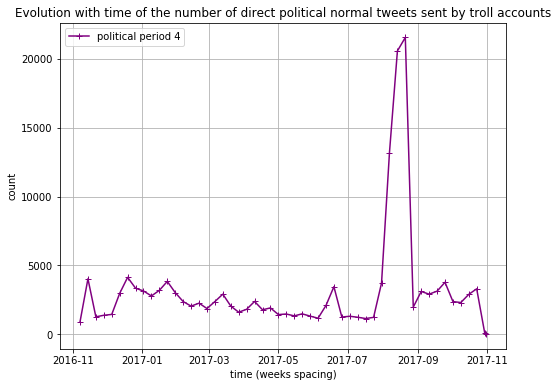

In [337]:
plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p4_pd["time"],political_normal_dates_w_p4_pd["count"],color="purple",marker='+')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 4'],loc=2);

----------------------------------------------------------------------